# Gradient Boosting Trees for Energy Forecasting (Real Data)

This notebook demonstrates the use of **Gradient Boosting Trees** for short-term energy forecasting using
**real hourly power load and temperature data** from the GitHub CSV:

```
https://github.com/vmpreciado/ESE538/blob/main/midatlantic_august2024_combined.csv
```

---

### Workflow
1. **Load data** directly from GitHub (raw URL) and parse timestamps.
2. **Normalize columns** into a consistent schema:
   - `demand`: total power load (MW)
   - `temp`: temperature (°C)
3. **Engineer features**: lags, rolling averages, STL trend/seasonal components, calendar variables, and temperature covariates.
4. **Train** a Gradient Boosting Trees model (`HistGradientBoostingRegressor`) using a **chronological train/val/test split**.
   - ⚠️ In time series forecasting, we must respect the temporal order: using random shuffles can cause **data leakage** by exposing the model to future information.
5. **Evaluate** model accuracy (RMSE/MAE), **visualize forecasts**, demonstrate **recursive multi-step forecasting**, and analyze **permutation feature importance**.

## 0) Setup & Imports

We begin by importing the core libraries for this notebook:

- **NumPy / pandas**: numerical operations and tabular data handling
- **Matplotlib**: plotting and visualization
- **scikit-learn**: machine learning models and utilities
  - `HistGradientBoostingRegressor`: our main forecasting model (gradient boosting trees)
  - `mean_absolute_error`, `mean_squared_error`: evaluation metrics
  - `permutation_importance`: to assess feature importance

We also fix the random seed for reproducibility and configure matplotlib plotting defaults.

In [20]:
# Core scientific libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Machine learning model: Gradient Boosting Trees (histogram-based implementation)
from sklearn.ensemble import HistGradientBoostingRegressor

# Metrics: absolute error, squared error
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Tool for assessing feature importance by permutation
from sklearn.inspection import permutation_importance

# Set random seed to ensure reproducibility of results
np.random.seed(42)

# Configure matplotlib defaults: figure size and grid lines
plt.rcParams['figure.figsize'] = (9, 4)
plt.rcParams['axes.grid'] = True

## 1) Load the CSV from GitHub and parse timestamps

We load the dataset directly from the GitHub repository (raw CSV file).
Steps performed:

1. **Read CSV** and parse the `datetime` column into proper Python datetimes.
2. **Set the datetime as index** and sort chronologically (important for time series).
3. **Rename columns** to a consistent schema used throughout this notebook:
   - `demand`: total power load (MW)
   - `temp`: temperature (°C)
4. **Drop missing values** to ensure a clean dataset.

In [21]:
# URL of the CSV file in the GitHub repository (raw format)
RAW_URL = "https://raw.githubusercontent.com/vmpreciado/ESE538/main/midatlantic_august2024_combined.csv"

# 1. Load CSV into a DataFrame
#    - parse_dates ensures 'datetime' column is converted to datetime dtype
df = pd.read_csv(RAW_URL, parse_dates=['datetime'])

# 2. Set 'datetime' as index and ensure chronological order
df = df.set_index('datetime').sort_index()

# 3. Rename relevant columns to match the schema used in this notebook
#    - total_power_load_MW → demand
#    - temperature_C → temp
data = df.rename(columns={
    'total_power_load_MW': 'demand',
    'temperature_C': 'temp'
})[['demand', 'temp']].dropna()   # keep only the selected columns and drop NaNs

# 4. Inspect the loaded dataset
print(data.head())   # preview the first few rows
print("Loaded rows:", len(data),
      " Range:", data.index.min(), "to", data.index.max())

                      demand  temp
datetime                          
2024-08-01 00:00:00  2421894  22.9
2024-08-01 01:00:00  2322910  22.9
2024-08-01 02:00:00  2415240  22.8
2024-08-01 03:00:00  2236486  23.8
2024-08-01 04:00:00  1056416  23.8
Loaded rows: 744  Range: 2024-08-01 00:00:00 to 2024-08-31 23:00:00


### Quick look at the raw series

Before feature engineering, we visualize the raw data to understand its structure:

- **Demand (MW):** clear daily and weekly cycles are expected.
- **Temperature (°C):** typically exhibits slower seasonal variations with daily fluctuations.

We plot the **first ~3 weeks** of the dataset for both series.

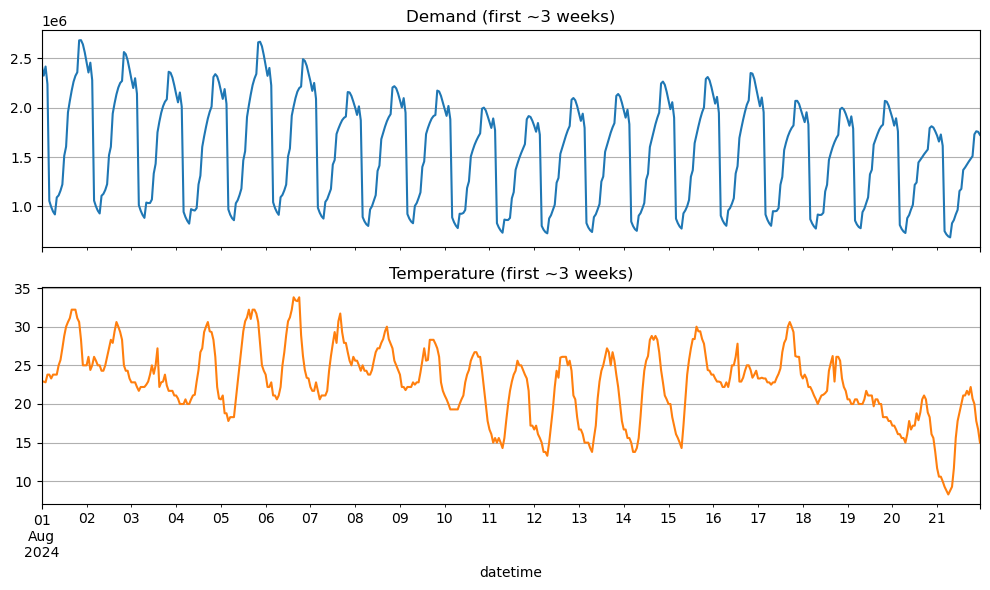

In [22]:
# Create a figure with two stacked subplots (demand on top, temperature below)
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Plot demand for the first ~3 weeks (21 days * 24 hours = 504 points)
data['demand'].iloc[:24*21].plot(
    ax=ax[0],
    title='Demand (first ~3 weeks)'
)

# Plot temperature for the same period, using a contrasting color
data['temp'].iloc[:24*21].plot(
    ax=ax[1],
    title='Temperature (first ~3 weeks)',
    color='tab:orange'
)

# Adjust subplot layout and display the plots
plt.tight_layout()
plt.show()

## 2) Feature engineering

We now construct the feature vector $\boldsymbol{\phi}_k$, which encodes past information and exogenous inputs into a tabular format suitable for machine learning models:

- **Lags:** recent demand values at k−1, k−2, k−24 (yesterday), and k−48 (two days ago).
- **Rolling stats:** 24-hour moving average to capture the local level.
- **STL components (period = 24):** decompose the demand series into daily **trend** and **seasonal** components.
- **Calendar:** categorical time features (hour of day, day of week).
- **Exogenous:** temperature at time k, plus a smoothed 24-hour moving average of temperature.

This process transforms the raw time series into a supervised-learning-ready feature matrix.

In [23]:
from statsmodels.tsa.seasonal import STL

def add_time_features(df):
    """
    Enrich the dataframe with engineered features for forecasting.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain columns 'demand' and 'temp', indexed by datetime.

    Returns
    -------
    pd.DataFrame with additional feature columns.
    """
    out = df.copy()

    # --- Lag features (autoregressive terms) ---
    out['lag_1']  = out['demand'].shift(1)    # last hour
    out['lag_2']  = out['demand'].shift(2)    # two hours ago
    out['lag_24'] = out['demand'].shift(24)   # one day ago
    out['lag_48'] = out['demand'].shift(48)   # two days ago

    # --- Rolling statistics ---
    out['ma_24']  = out['demand'].rolling(24).mean()  # 24-hour moving average

    # --- STL decomposition (daily period = 24) ---
    # Trend and seasonal components capture systematic daily patterns
    stl = STL(out['demand'], period=24, robust=True)
    res = stl.fit()
    out['stl_trend_24']    = res.trend
    out['stl_seasonal_24'] = res.seasonal

    # --- Calendar features ---
    out['hour'] = out.index.hour       # hour of day (0–23)
    out['dow']  = out.index.dayofweek  # day of week (0=Monday,...,6=Sunday)

    # --- Exogenous temperature features ---
    out['temp_0']     = out['temp']                     # current temperature
    out['temp_ma_24'] = out['temp'].rolling(24).mean()  # 24-hour average temperature

    return out

# Apply feature engineering and drop rows with NaNs introduced by lags/rolling
feat = add_time_features(data).dropna()

# Define predictors and target
X_cols = [
    'lag_1','lag_2','lag_24','lag_48',
    'ma_24',
    'stl_trend_24','stl_seasonal_24',
    'hour','dow',
    'temp_0','temp_ma_24'
]
y_col  = 'demand'

# Preview first rows of the engineered dataset
feat.head()

,demand,temp,lag_1,lag_2,lag_24,lag_48,ma_24,stl_trend_24,stl_seasonal_24,hour,dow,temp_0,temp_ma_24
datetime,,,,,,,,,,,,,
2024-08-03 00:00:00,2289036,22.8,2387158.0,2478084.0,2454904.0,2421894.0,1.828270e+06,1.773837e+06,521795.623629,0,5,22.8,26.150000
2024-08-03 01:00:00,2197954,22.8,2289036.0,2387158.0,2354856.0,2322910.0,1.821733e+06,1.767549e+06,434120.841937,1,5,22.8,26.012500
2024-08-03 02:00:00,2296768,22.8,2197954.0,2289036.0,2454052.0,2415240.0,1.815179e+06,1.761091e+06,533183.118307,2,5,22.8,25.945833
2024-08-03 03:00:00,2138868,22.2,2296768.0,2197954.0,2277220.0,2236486.0,1.809415e+06,1.754537e+06,375917.689254,3,5,22.2,25.829167
2024-08-03 04:00:00,1014202,21.7,2138868.0,2296768.0,1059326.0,1056416.0,1.807534e+06,1.747977e+06,-755882.745658,4,5,21.7,25.645833


## 3) Time-based split

We partition the dataset strictly in chronological order (no random shuffling, to avoid leakage):

- First **70%** → training set
- Next **15%** → validation set (used for hyperparameter tuning)
- Final **15%** → test set (held-out for out-of-sample evaluation)

The figure below shows the demand series with the three regions highlighted.

Train shape: (487, 11)
Val shape:   (104, 11)
Test shape:  (105, 11)


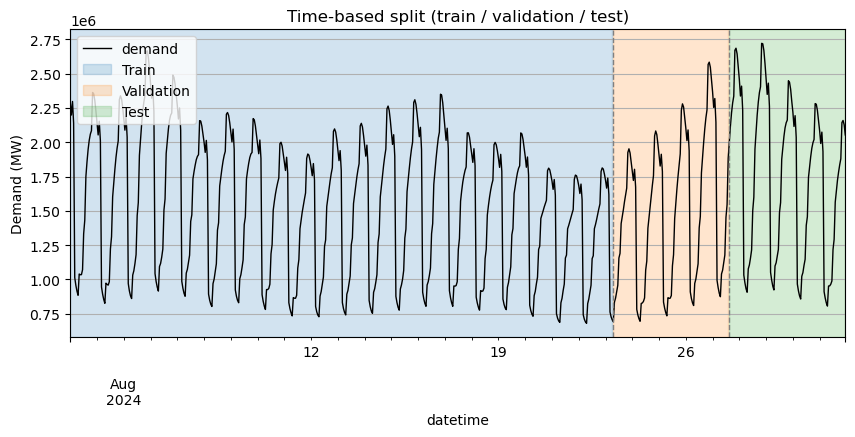

In [24]:
# Total number of samples
N = len(feat)

# Compute split indices (chronological partition)
i_train = int(0.70 * N)   # 70% for training
i_val   = int(0.85 * N)   # next 15% for validation
# remaining 15% is for test

# Partition features and target
X_train, y_train = feat.iloc[:i_train][X_cols], feat.iloc[:i_train][y_col]
X_val,   y_val   = feat.iloc[i_train:i_val][X_cols], feat.iloc[i_train:i_val][y_col]
X_test,  y_test  = feat.iloc[i_val:][X_cols], feat.iloc[i_val:][y_col]

# Print dataset shapes
print("Train shape:", X_train.shape)
print("Val shape:  ", X_val.shape)
print("Test shape: ", X_test.shape)

# --- Plot the demand series with shaded regions for train/val/test ---
fig, ax = plt.subplots(figsize=(10, 4))
feat['demand'].plot(ax=ax, color="black", lw=1, title="Time-based split (train / validation / test)")

# Shaded spans
ax.axvspan(y_train.index[0], y_train.index[-1], alpha=0.2, color="tab:blue",   label="Train")
ax.axvspan(y_val.index[0],   y_val.index[-1],   alpha=0.2, color="tab:orange", label="Validation")
ax.axvspan(y_test.index[0],  y_test.index[-1],  alpha=0.2, color="tab:green",  label="Test")

# Vertical dashed lines at split boundaries
ax.axvline(y_val.index[0],  color="gray", linestyle="--", lw=1)
ax.axvline(y_test.index[0], color="gray", linestyle="--", lw=1)

ax.set_ylabel("Demand (MW)")
ax.legend(loc="upper left")  # legend in the upper left corner
plt.show()

## 4) Train Gradient Boosting Trees + Interpretable Metrics

We train a **Histogram-based Gradient Boosting Trees (HGBT)** model on the engineered features:

- **Lags:** `lag_1`, `lag_2`, `lag_24`, `lag_48`
- **Rolling:** `ma_24`
- **STL (daily):** `stl_trend_24`, `stl_seasonal_24`
- **Calendar:** `hour`, `dow`
- **Exogenous:** `temp_0`, `temp_ma_24`

📌 *Histogram-based* means that continuous feature values are **binned into histograms** (e.g. ~256 bins) so the algorithm only evaluates split points at bin boundaries.
This makes training much **faster and more memory-efficient**, with almost no loss in accuracy.

To make evaluation **scale-aware** and **comparable**, we report:

- **RMSE / MAE:** absolute error measures (RMSE penalizes large errors).
- **nRMSE:** normalized RMSE $=\text{RMSE} / \overline{y}$, interpreted as *% of average demand*.
- **MAPE:** mean absolute percentage error (in %).
- **Skill score (vs. seasonal naïve):**
  Seasonal naïve uses yesterday’s value as the 1-step forecast $(\hat y_{t+1} = y_{t+1-24})$.
  $$
  \text{Skill} = 1 - \frac{\text{RMSE}_{\text{model}}}{\text{RMSE}_{\text{baseline}}}
  $$
  Positive values indicate improvement over the baseline; 0 means no gain.

In [25]:
from sklearn.metrics import mean_squared_error

# -----------------------------
# 1) Define and train the model
# -----------------------------
hgb = HistGradientBoostingRegressor(
    max_depth=6,            # individual tree depth
    learning_rate=0.05,     # shrinkage per boosting stage
    max_iter=500,           # number of trees
    l2_regularization=0.0,  # can help reduce overfitting
    early_stopping=True,    # stop when internal val score stalls
    validation_fraction=0.1,
    random_state=42
)

hgb.fit(X_train, y_train)

# -----------------------------
# 2) Predict on val / test
# -----------------------------
pred_val  = hgb.predict(X_val)
pred_test = hgb.predict(X_test)

# -----------------------------
# 3) Build seasonal naïve baselines (y_{t} ≈ y_{t-24})
#    We can use the already engineered 'lag_24' feature aligned to each split
# -----------------------------
baseline_val  = X_val['lag_24'].values
baseline_test = X_test['lag_24'].values

# -----------------------------
# 4) Metric helpers (with normalization, MAPE, and Skill)
# -----------------------------
def rmse(y, yhat):
    return np.sqrt(mean_squared_error(y, yhat))

def mae(y, yhat):
    return mean_absolute_error(y, yhat)

def nrmse(y, yhat):
    """Normalized RMSE: RMSE divided by mean of y."""
    mean_y = np.mean(y)
    return rmse(y, yhat) / mean_y if mean_y != 0 else np.nan

def mape(y, yhat, eps=1e-8):
    """Mean Absolute Percentage Error in %, with small eps to avoid div-by-zero."""
    y = np.asarray(y)
    yhat = np.asarray(yhat)
    return np.mean(np.abs((y - yhat) / np.maximum(np.abs(y), eps))) * 100.0

def skill_vs_baseline(y, yhat, ybase):
    """Skill score relative to a baseline: 1 - RMSE(model)/RMSE(baseline)."""
    rmse_model = rmse(y, yhat)
    rmse_base  = rmse(y, ybase)
    return 1.0 - (rmse_model / rmse_base) if rmse_base != 0 else np.nan

# -----------------------------
# 5) Compute and present metrics (Validation & Test)
# -----------------------------
val_metrics = {
    "RMSE": rmse(y_val, pred_val),
    "MAE":  mae(y_val,  pred_val),
    "nRMSE": nrmse(y_val, pred_val),
    "MAPE (%)": mape(y_val, pred_val),
    "Skill vs seasonal-naive": skill_vs_baseline(y_val, pred_val, baseline_val)
}

test_metrics = {
    "RMSE": rmse(y_test, pred_test),
    "MAE":  mae(y_test,  pred_test),
    "nRMSE": nrmse(y_test, pred_test),
    "MAPE (%)": mape(y_test, pred_test),
    "Skill vs seasonal-naive": skill_vs_baseline(y_test, pred_test, baseline_test)
}

# Tidy table for display
metrics_df = pd.DataFrame([val_metrics, test_metrics], index=["Validation", "Test"])
display(metrics_df.style.format({
    "RMSE": "{:.2f}",
    "MAE": "{:.2f}",
    "nRMSE": "{:.2%}",
    "MAPE (%)": "{:.2f}",
    "Skill vs seasonal-naive": "{:.2%}"
}).set_caption("HGBT performance with normalized metrics and baseline skill"))

# (Optional) quick prints for notebooks without rich display
print("\nValidation:", metrics_df.loc["Validation"].to_dict())
print("Test      :", metrics_df.loc["Test"].to_dict())

,RMSE,MAE,nRMSE,MAPE (%),Skill vs seasonal-naive
Validation,58959.91,43322.75,3.96%,2.92,60.36%
Test,63941.15,43307.52,3.61%,2.35,48.13%



Validation: {'RMSE': 58959.914767118054, 'MAE': 43322.749236323405, 'nRMSE': 0.03958616071401429, 'MAPE (%)': 2.9230098678949537, 'Skill vs seasonal-naive': 0.6036160433897665}
Test      : {'RMSE': 63941.14950867773, 'MAE': 43307.52305405534, 'nRMSE': 0.03612480094192559, 'MAPE (%)': 2.3451699719526067, 'Skill vs seasonal-naive': 0.4813382458073945}


### Forecast visualization on the test window

We compare the **true demand series** against the **Gradient Boosted Trees (GBT) forecasts**.
The model leverages the engineered features (lags, rolling statistics, STL components, calendar, temperature).

Below we plot the **first 7 days of the test split** to inspect how well the model tracks short-term variations.

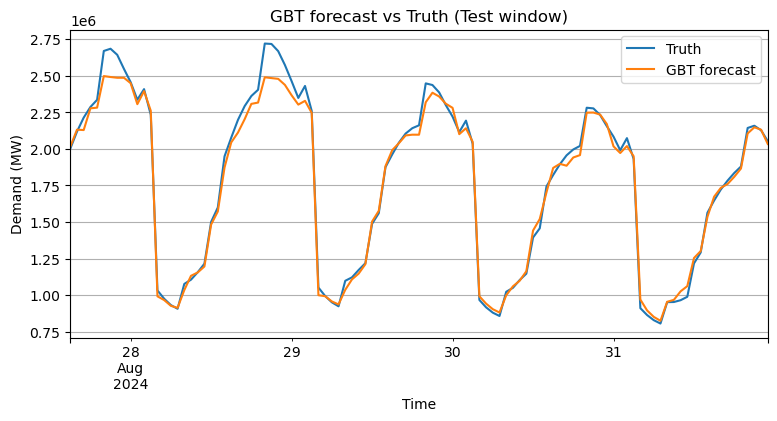

In [37]:
# --- Plot actual demand vs GBT forecast for the first 7 days of the test set ---

# Plot the ground truth demand
ax = y_test.iloc[:24*7].plot(
    label='Truth',
    title='GBT forecast vs Truth (Test window)',
    legend=True
)

# Plot the model forecasts for the same period
pd.Series(pred_test, index=y_test.index).iloc[:24*7].plot(
    ax=ax,
    label='GBT forecast'
)

# Add axis labels and legend
plt.ylabel('Demand (MW)')
plt.xlabel('Time')
plt.legend()
plt.show()

## 6) Permutation feature importance (validation set)

We assess feature importance using **permutation importance**:

- Each feature is randomly shuffled (permuted) in the **validation set**, breaking its relationship with the target.   In practice, this means we take one column (e.g., temp) and randomly reorder its values across all rows. After shuffling, the temperature at a given time no longer matches the actual demand at that time, while all the other features and the target remain unchanged.
- The resulting **drop in model performance** (RMSE) is measured.
- Larger drops indicate features that are more critical for the model’s predictive power.

📌 Using the **validation set** (not training) ensures we measure importance on *unseen data*,
avoiding overfitting and giving a realistic view of how much each feature contributes to generalization.

The model was trained on the engineered features:

- **Lags:** `lag_1`, `lag_2`, `lag_24`, `lag_48`
- **Rolling:** `ma_24`
- **STL (daily period=24):** `stl_trend_24`, `stl_seasonal_24`
- **Calendar:** `hour`, `dow`
- **Exogenous:** `temp_0`, `temp_ma_24`

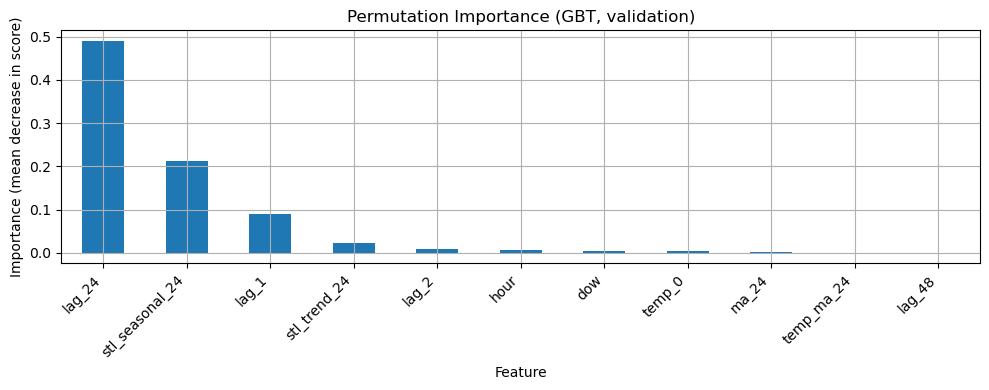

,mean_importance,std_importance
lag_24,0.490182,0.046136
stl_seasonal_24,0.211478,0.023971
lag_1,0.089499,0.005280
stl_trend_24,0.022400,0.002221
lag_2,0.009088,0.001251
hour,0.005854,0.000534
dow,0.003957,0.000837
temp_0,0.002858,0.000302
ma_24,0.000877,0.000790
temp_ma_24,0.000057,0.000119


In [31]:
from sklearn.inspection import permutation_importance

# Permutation importance on the validation split
perm = permutation_importance(
    hgb, X_val, y_val,
    n_repeats=5,
    random_state=42
)

imp = pd.Series(perm.importances_mean, index=X_cols).sort_values(ascending=False)

# Plot nicely
ax = imp.plot(kind='bar', title='Permutation Importance (GBT, validation)', figsize=(10, 4))
ax.set_ylabel('Importance (mean decrease in score)')
ax.set_xlabel('Feature')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Also return a tidy table with mean and std across repeats
imp_tbl = pd.DataFrame({
    'mean_importance': perm.importances_mean,
    'std_importance':  perm.importances_std
}, index=X_cols).sort_values('mean_importance', ascending=False)

imp_tbl

## 7) Simple linear model with top-4 features

To benchmark the Gradient Boosted Trees (GBT), we fit a plain **LinearRegression** model using the four most important features identified by permutation importance:

- `lag_24`
- `stl_seasonal_24`
- `lag_1`
- `stl_trend_24`

We then compare performance on validation and test splits against the full GBT model, and also inspect the **coefficients and p-values** of the linear model for interpretability.

In [32]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import pandas as pd

top4 = ['lag_24','stl_seasonal_24','lag_1','stl_trend_24']

# --- Fit a simple linear regression on the training split ---
lin = LinearRegression()
lin.fit(X_train[top4], y_train)

# Predictions on validation and test splits
pred_val_lin  = lin.predict(X_val[top4])
pred_test_lin = lin.predict(X_test[top4])

# Metrics helper
def rmse(y, yhat):
    return np.sqrt(mean_squared_error(y, yhat))

# --- Compare metrics side-by-side with GBT ---
metrics = pd.DataFrame({
    'RMSE (val)':  [rmse(y_val, pred_val),  rmse(y_val, pred_val_lin)],
    'MAE (val)':   [mean_absolute_error(y_val, pred_val),  mean_absolute_error(y_val, pred_val_lin)],
    'RMSE (test)': [rmse(y_test, pred_test), rmse(y_test, pred_test_lin)],
    'MAE (test)':  [mean_absolute_error(y_test, pred_test), mean_absolute_error(y_test, pred_test_lin)],
}, index=['GBT (all features)','Linear (top-4)'])

display(metrics.style.format("{:.2f}").set_caption("GBT vs Linear (top-4 features)"))

# --- Refit linear model with statsmodels to extract p-values ---
X_train_sm = sm.add_constant(X_train[top4])  # add intercept
ols_model = sm.OLS(y_train, X_train_sm).fit()

# Coefficients and p-values (rounded for clarity)
coef_pval_tbl = pd.DataFrame({
    'coef': ols_model.params.round(4),
    'p_value': ols_model.pvalues.round(4)
}).loc[['const'] + top4]

display(coef_pval_tbl.style.set_caption("Linear model coefficients and p-values"))

,RMSE (val),MAE (val),RMSE (test),MAE (test)
GBT (all features),58959.91,43322.75,63941.15,43307.52
Linear (top-4),40175.94,27420.68,63507.41,41281.81


,coef,p_value
const,-39069.457900,0.148300
lag_24,-0.085600,0.000700
stl_seasonal_24,1.039200,0.000000
lag_1,0.053300,0.000000
stl_trend_24,1.059100,0.000000


### 7.1) Visual comparison on the full test span

We overlay the **true demand** with the **GBT forecasts** (all features) and the **Linear model** (top-4 features) across the **entire test window**.
This view highlights overall alignment, drift, and any systematic gaps between models over the full evaluation period.

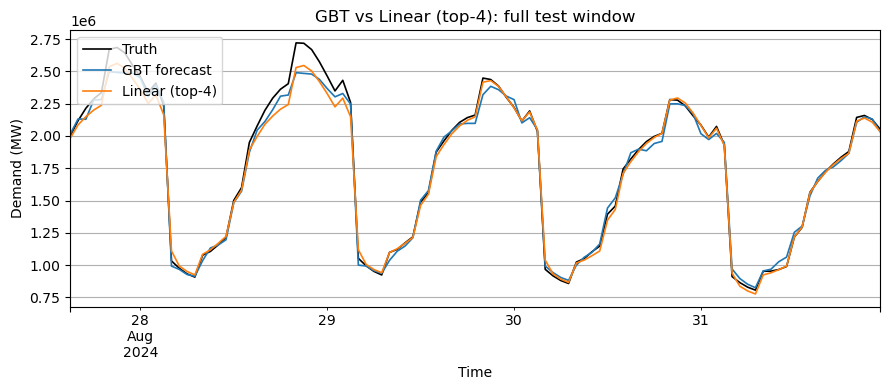

In [36]:
# --- Full test span: truth vs GBT (all features) vs Linear (top-4) ---

# Plot ground-truth demand over the entire test window
ax = y_test.plot(
    label='Truth',
    title='GBT vs Linear (top-4): full test window',
    legend=True,
    linewidth=1.2,
    color='black'
)

# Overlay GBT predictions
pd.Series(pred_test, index=y_test.index).plot(
    ax=ax,
    label='GBT forecast',
    linewidth=1.2
)

# Overlay Linear (top-4) predictions
pd.Series(pred_test_lin, index=y_test.index).plot(
    ax=ax,
    label='Linear (top-4)',
    linewidth=1.2
)

# Axis labels and legend placement
plt.ylabel('Demand (MW)')
plt.xlabel('Time')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()